In [1]:
import itertools
import math
import pickle
import random
from collections import defaultdict

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import PIL.Image
import seaborn as sns
import scipy.ndimage
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import tqdm

from IPython.core.display import Image, display

%matplotlib inline
%autosave 15

Autosaving every 15 seconds


# Загружаем датасет

In [2]:
with open('./data/hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./data/hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

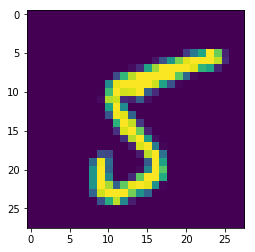

In [3]:
# Пример, как можно визуализировать данные
plt.imshow(train['data'][0].reshape(28,28));

# Обучаем модель

In [95]:
# Считаем данные
n_samples, n_features = train["data"].shape
X = np.column_stack((np.ones(n_samples), train["data"].copy()))

# Стандартизуем фичи
scaling_mean = X.mean()
scaling_std = X.std() + 1e-4
X = (X - scaling_mean) / scaling_std

# Приведём метки классов к {-1, 1}
y = train["labels"].copy()[:, None]
y[y == 5] = -1
y[y == 6] = 1

# Разобьём на обучающую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.09, 
    random_state=0
)

In [190]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def logit(X, w):
    return sigmoid(X @ w)


def predict(X, w):
    return 2 * (logit(X, w) > 0.5) - 1


def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()


def loss_grad_full(X, y, w, regparam):
#     grad = np.zeros((X.shape[1], 1))
#     for i in range(X.shape[1]):
#         features = X[i, :].reshape(-1, 1)
#         grad += y[i]  / (1 + np.exp(y[i] * theta.T @ features)) * features
#     return grad
    regvec = weights
    regvec[0] = 0
    return -X.T @ (y / (1 + np.exp(y * (X @ w))) ) + regparam * regvec


def loss_grad_stoch(X, y, w, regparam):
    grad = np.zeros((X.shape[1], 1))
    for i in range(X.shape[1]):
        j = np.random.randint(0, X.shape[0])
        fvec = X[j][:, None]
        grad += -y[j]  / (1 + np.exp(y[j] * w.T @ fvec)) * fvec + regparam * fvec      
    return grad

In [233]:
max_iter = 1000

# Выберем случайное начальное приближение вектора параметров
weights = np.random.normal(scale=1e-3, size=n_features + 1)[:, None]
tr_eval = []
te_eval = []
tolerance = 1e-15

for i in tqdm.tqdm_notebook(range(max_iter)):
    learning_rate = 0.1 / (i + 1)
    grad = loss_grad_full(X_train, y_train, weights, regparam=10)
    if learning_rate * np.linalg.norm(grad) < tolerance:
        break
    weights -= learning_rate * grad
#     y_train_pred = predict(X_train, weights)
#     tr_eval += [(log_loss(y_train, y_train_pred), 
#                 accuracy(y_train, y_train_pred))]
#     y_test_pred = predict(X_test, weights)
#     te_eval += [(log_loss(y_test, y_test_pred), 
#                 accuracy(y_test, y_test_pred))]

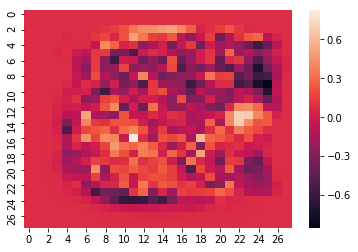

In [234]:
sns.heatmap(weights[1:].reshape(28,28))

In [235]:
sps.describe(weights)

DescribeResult(nobs=785, minmax=(array([-0.85310628]), array([0.82413651])), mean=array([0.01095999]), variance=array([0.04353099]), skewness=array([-0.59202048]), kurtosis=array([1.83009125]))

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

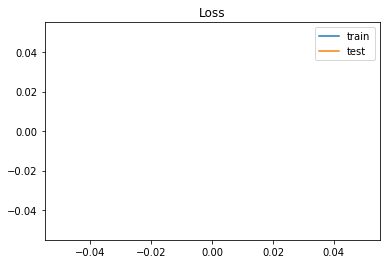

In [236]:
plt.title('Loss')
plt.plot([e[0] for e in tr_eval], label='train')
plt.plot([e[0] for e in te_eval], label='test')
plt.legend();

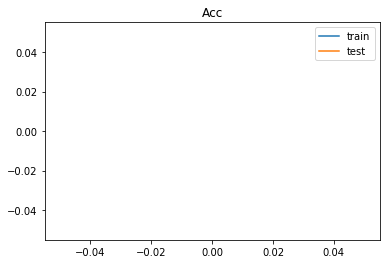

In [237]:
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend();

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [238]:
te_X = test_no_lables['data']
te_X = np.column_stack((np.ones(te_X.shape[0]), te_X))
te_X = (te_X - scaling_mean) / scaling_std
te_y_pred = logit(te_X, weights)

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(te_y_pred.size):
        print(i, te_y_pred[i], sep=',', file=fout)

(array([1491.,   16.,   16.,   13.,    7.,    9.,    7.,   16.,   33.,
        1581.]),
 array([2.18679643e-24, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

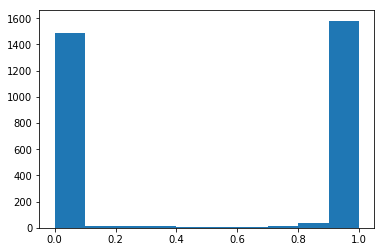

In [239]:
plt.hist(te_y_pred)

In [159]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score

lm = LogisticRegression(max_iter=100000, C=1, penalty="l2")
lm.fit(X_train, y_train.ravel())

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='ovr',
          n_jobs=1, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

(array([1490.,   23.,   12.,    9.,    7.,   10.,   10.,   15.,   22.,
        1591.]),
 array([1.03296591e-32, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

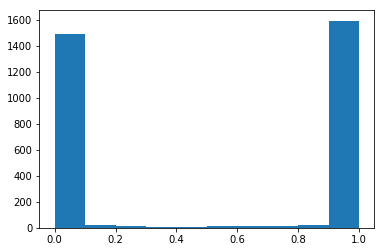

In [214]:
plt.hist(lm.predict_proba(te_X)[:,1])

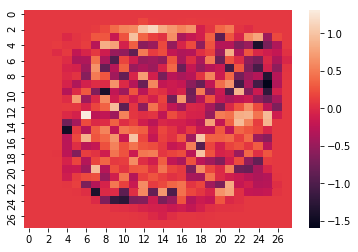

In [210]:
sns.heatmap(lm.coef_[0, 1:].reshape(28,28))

(array([1424.,   54.,   22.,   12.,   20.,   16.,   20.,   22.,   58.,
        1541.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

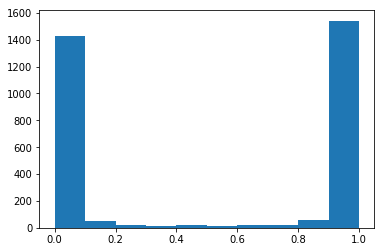

In [105]:
plt.hist(pd.read_csv("Feofanova.csv")["Prediction"])

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/34e77301ef914c5792e4f4306144a6b3 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МФТИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем <ваша фамилия>.ipynb